In [77]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/florian/GitRepos/activeCell-ACDC
ac_acdc_env  local	output		  requirements.txt  utils
al_output    log	pipeline_configs  shell_scripts     wandb
data	     notebooks	README.md	  src


## Initialization

In [78]:
dataset = ACDC_LARGE_CLS
config_name = "classes_acdc_large_al"

model_path = "/home/florian/GitRepos/activeCell-ACDC/al_output/classes_acdc_large_al/random/best_model55.pth"


In [79]:
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][1]
))

registering acdc_small dataset
registering acdc_large dataset
registering acdc_large_cls dataset


In [80]:
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

In [81]:
default_cfg = get_config(config_name)
cfg = default_cfg
cfg.OUTPUT_DIR = "./al_output/classes_acdc_large_al"
cfg.AL.OBJECT_TO_IMG_AGG = "mean"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2

## Initialize Uncertainty Methods

In [82]:
query_strategy = MCDropoutSampler(cfg)
model = load_model(cfg, model_path)
model = patch_module(model)


rd.seed(1337)
sample_data = rd.sample(train_data, 10)


In [83]:
def val2dicts(val):

    preds = []
    for v in val:
        pred_masks = v["pred_masks"].detach().cpu().numpy()
        pred_classes = v["pred_classes"].detach().cpu().numpy()

        preds.append({
            "pred_masks": pred_masks,
            "pred_classes": pred_classes,
        })

    return preds

def get_uncertainties(im_json, model, query_strategy):

    im = query_strategy.load_image(im_json)
    instance_list = query_strategy.get_samples(model, im, cfg.AL.NUM_MC_SAMPLES)
    combinded_instances = query_strategy.get_combinded_instances(instance_list)


    height, width = im.shape[:2]
    uncertainties = []

    for key, val in combinded_instances.items():

        val_len = torch.tensor(len(val)).to("cuda")

        if query_strategy.cfg.MODEL.ROI_HEADS.NUM_CLASSES > 1:
            u_sem = query_strategy.get_semantic_certainty(val, device = "cuda").detach().cpu().numpy()
        else:
            u_sem = 0
        u_mask = query_strategy.get_mask_certainty(val, height, width, val_len, device="cuda").detach().cpu().numpy()
        u_box = query_strategy.get_box_certainty(val, val_len, device="cuda").detach().cpu().numpy()
        u_det = query_strategy.get_detection_certainty(cfg.AL.NUM_MC_SAMPLES, val_len, device="cuda").detach().cpu().numpy()
        
        

        cpu_val = val2dicts(val)

        uncertainties.append({
            "val": cpu_val,
            "u_sem": u_sem,
            "u_mask": u_mask,
            "u_box": u_box,
            "u_det": u_det,

        })


    
    return uncertainties





    

acdc_data3_Yagya_SCGE_WT_pos_4_19
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


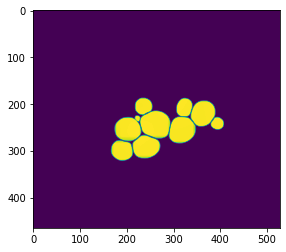

number of detections 40 u_sem 0.99994737 u_mask 0.9423421 u_box 0.94281137 u_det 1.0
number of detections 40 u_sem 0.99951404 u_mask 0.94017583 u_box 0.9485577 u_det 1.0
number of detections 40 u_sem 0.9993246 u_mask 0.94012636 u_box 0.94466895 u_det 1.0
number of detections 54 u_sem 0.85799015 u_mask 0.9335523 u_box 0.92270094 u_det 1.0
number of detections 40 u_sem 0.99568886 u_mask 0.93213016 u_box 0.9424035 u_det 1.0
number of detections 40 u_sem 0.98976195 u_mask 0.8630085 u_box 0.9243935 u_det 1.0
number of detections 63 u_sem 0.7696539 u_mask 0.9301717 u_box 0.9167803 u_det 1.0
number of detections 40 u_sem 0.98781854 u_mask 0.9430174 u_box 0.93934554 u_det 1.0
number of detections 50 u_sem 0.8747512 u_mask 0.924689 u_box 0.9236262 u_det 1.0
number of detections 80 u_sem 0.56950355 u_mask 0.9107572 u_box 0.9075426 u_det 1.0
acdc_data3_Yagya_SCD_WT_pos_4_8
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0

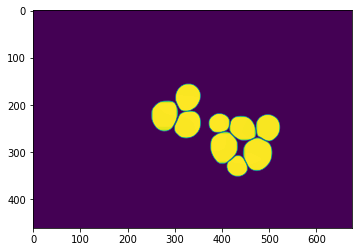

number of detections 40 u_sem 0.9992985 u_mask 0.95010245 u_box 0.9536692 u_det 1.0
number of detections 40 u_sem 0.99912685 u_mask 0.9338753 u_box 0.92757195 u_det 1.0
number of detections 40 u_sem 0.996171 u_mask 0.9130477 u_box 0.9180538 u_det 1.0
number of detections 40 u_sem 0.99798393 u_mask 0.93594944 u_box 0.92687064 u_det 1.0
number of detections 41 u_sem 0.98201936 u_mask 0.9317242 u_box 0.93743545 u_det 1.0
number of detections 43 u_sem 0.9592436 u_mask 0.9432275 u_box 0.9351022 u_det 1.0
number of detections 40 u_sem 0.9977606 u_mask 0.94877183 u_box 0.9540995 u_det 1.0
number of detections 40 u_sem 0.9968883 u_mask 0.9372057 u_box 0.932261 u_det 1.0
number of detections 46 u_sem 0.9045503 u_mask 0.92879725 u_box 0.9321813 u_det 1.0
acdc_data3_20210722_pos_17_42
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='

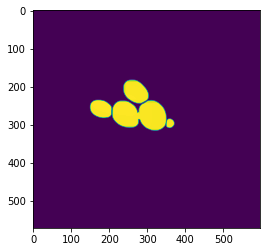

number of detections 40 u_sem 0.999849 u_mask 0.9379984 u_box 0.9376106 u_det 1.0
number of detections 40 u_sem 0.99960345 u_mask 0.94611335 u_box 0.93653715 u_det 1.0
number of detections 40 u_sem 0.9994151 u_mask 0.9393235 u_box 0.93334883 u_det 1.0
number of detections 40 u_sem 0.9988608 u_mask 0.9309316 u_box 0.94251966 u_det 1.0
number of detections 56 u_sem 0.81032985 u_mask 0.92112607 u_box 0.9259962 u_det 1.0
number of detections 2 u_sem 0.5026401 u_mask 0.9015151 u_box 0.94057965 u_det 0.81


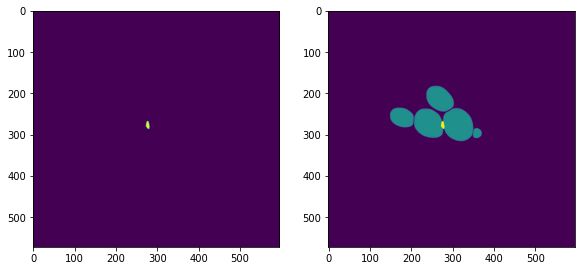

acdc_data3_Yagya_SCGE_WT_pos_2_141
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0

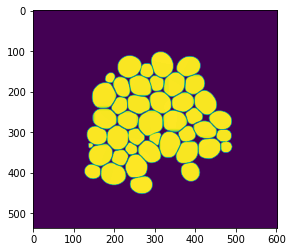

number of detections 40 u_sem 0.99903435 u_mask 0.9218371 u_box 0.9500724 u_det 1.0
number of detections 40 u_sem 0.9986467 u_mask 0.9466209 u_box 0.9516735 u_det 1.0
number of detections 40 u_sem 0.99538344 u_mask 0.951 u_box 0.96180856 u_det 1.0
number of detections 40 u_sem 0.99532473 u_mask 0.9430336 u_box 0.9598179 u_det 1.0
number of detections 40 u_sem 0.9953554 u_mask 0.9405836 u_box 0.9399195 u_det 1.0
number of detections 40 u_sem 0.99862355 u_mask 0.93021536 u_box 0.95161057 u_det 1.0
number of detections 40 u_sem 0.9925116 u_mask 0.9517134 u_box 0.94986117 u_det 1.0
number of detections 40 u_sem 0.99588597 u_mask 0.9473699 u_box 0.9495506 u_det 1.0
number of detections 40 u_sem 0.99174225 u_mask 0.93063134 u_box 0.9466626 u_det 1.0
number of detections 40 u_sem 0.9942797 u_mask 0.9468191 u_box 0.96180904 u_det 1.0
number of detections 40 u_sem 0.99517506 u_mask 0.9503287 u_box 0.95947933 u_det 1.0
number of detections 40 u_sem 0.9794647 u_mask 0.9366399 u_box 0.93519574 u_d

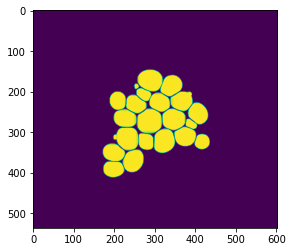

number of detections 40 u_sem 0.9991558 u_mask 0.9308984 u_box 0.94809896 u_det 1.0
number of detections 40 u_sem 0.99909097 u_mask 0.9420445 u_box 0.9423936 u_det 1.0
number of detections 40 u_sem 0.9971367 u_mask 0.9345881 u_box 0.9445422 u_det 1.0
number of detections 40 u_sem 0.99735224 u_mask 0.9491199 u_box 0.95453274 u_det 1.0
number of detections 40 u_sem 0.9801893 u_mask 0.93699664 u_box 0.9439438 u_det 1.0
number of detections 40 u_sem 0.99339026 u_mask 0.9423467 u_box 0.94562703 u_det 1.0
number of detections 43 u_sem 0.9306719 u_mask 0.9408162 u_box 0.9318294 u_det 1.0
number of detections 43 u_sem 0.94059324 u_mask 0.93714863 u_box 0.9345948 u_det 1.0
number of detections 43 u_sem 0.93541116 u_mask 0.9383052 u_box 0.9412682 u_det 1.0
number of detections 42 u_sem 0.94760525 u_mask 0.9469246 u_box 0.95243293 u_det 1.0
number of detections 70 u_sem 0.70510757 u_mask 0.9325149 u_box 0.9199186 u_det 1.0
number of detections 46 u_sem 0.8608159 u_mask 0.93796706 u_box 0.94388133

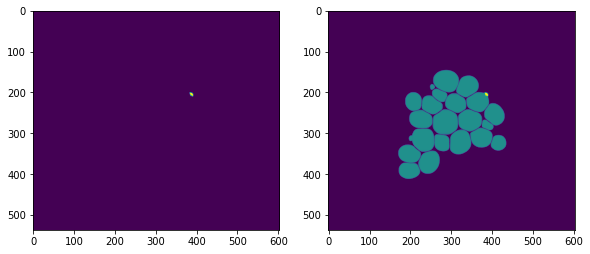

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_8_24
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


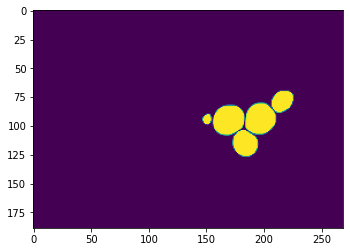

number of detections 40 u_sem 0.99896616 u_mask 0.937774 u_box 0.9389855 u_det 1.0
number of detections 40 u_sem 0.99883825 u_mask 0.9214487 u_box 0.9323009 u_det 1.0
number of detections 40 u_sem 0.99470234 u_mask 0.8858197 u_box 0.9382763 u_det 1.0
number of detections 67 u_sem 0.7088397 u_mask 0.9169392 u_box 0.9168274 u_det 1.0
number of detections 41 u_sem 0.98535675 u_mask 0.94097567 u_box 0.9363599 u_det 1.0
acdc_data2_kurt_306-3_20_20201105_pos_5_81
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


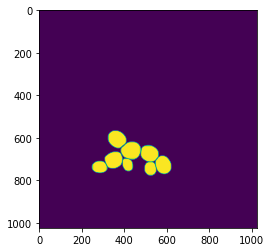

number of detections 40 u_sem 0.9987236 u_mask 0.94104636 u_box 0.9332277 u_det 1.0
number of detections 40 u_sem 0.9974949 u_mask 0.94065654 u_box 0.92892206 u_det 1.0
number of detections 40 u_sem 0.9953829 u_mask 0.90267694 u_box 0.9223965 u_det 1.0
number of detections 40 u_sem 0.994228 u_mask 0.92051667 u_box 0.92666185 u_det 1.0
number of detections 41 u_sem 0.97687286 u_mask 0.9260685 u_box 0.9223168 u_det 1.0
number of detections 42 u_sem 0.9625493 u_mask 0.9317123 u_box 0.9350394 u_det 1.0
number of detections 80 u_sem 0.5441944 u_mask 0.91195095 u_box 0.91742915 u_det 1.0
number of detections 80 u_sem 0.56986934 u_mask 0.923116 u_box 0.90913594 u_det 1.0
acdc_data3_20210722_pos_1_173
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0

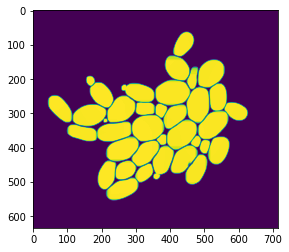

number of detections 40 u_sem 0.9998094 u_mask 0.93606114 u_box 0.95489216 u_det 1.0
number of detections 40 u_sem 0.9986145 u_mask 0.9297928 u_box 0.9460909 u_det 1.0
number of detections 40 u_sem 0.99939805 u_mask 0.9369991 u_box 0.9450449 u_det 1.0
number of detections 40 u_sem 0.99929905 u_mask 0.943831 u_box 0.95049417 u_det 1.0
number of detections 40 u_sem 0.9983781 u_mask 0.9390741 u_box 0.9523446 u_det 1.0
number of detections 40 u_sem 0.99754804 u_mask 0.9226354 u_box 0.95052445 u_det 1.0
number of detections 40 u_sem 0.9981642 u_mask 0.9355016 u_box 0.9351074 u_det 1.0
number of detections 40 u_sem 0.9968789 u_mask 0.93978816 u_box 0.95168513 u_det 1.0
number of detections 40 u_sem 0.99912494 u_mask 0.9430632 u_box 0.9515131 u_det 1.0
number of detections 40 u_sem 0.99245214 u_mask 0.92758375 u_box 0.93268347 u_det 1.0
number of detections 40 u_sem 0.99456465 u_mask 0.923254 u_box 0.932844 u_det 1.0
number of detections 40 u_sem 0.9853291 u_mask 0.94108033 u_box 0.9396 u_det

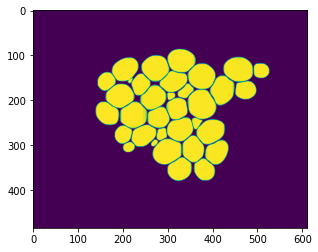

number of detections 40 u_sem 0.99957865 u_mask 0.9403894 u_box 0.9416167 u_det 1.0
number of detections 40 u_sem 0.9990136 u_mask 0.9490543 u_box 0.9574305 u_det 1.0
number of detections 40 u_sem 0.9995675 u_mask 0.9433003 u_box 0.95759696 u_det 1.0
number of detections 40 u_sem 0.99927086 u_mask 0.92619646 u_box 0.93353206 u_det 1.0
number of detections 40 u_sem 0.9984078 u_mask 0.93655807 u_box 0.9336815 u_det 1.0
number of detections 40 u_sem 0.99870867 u_mask 0.9386437 u_box 0.95762175 u_det 1.0
number of detections 40 u_sem 0.9926351 u_mask 0.93923455 u_box 0.9461147 u_det 1.0
number of detections 40 u_sem 0.9979483 u_mask 0.93859005 u_box 0.9418926 u_det 1.0
number of detections 40 u_sem 0.9981638 u_mask 0.9363487 u_box 0.93692 u_det 1.0
number of detections 40 u_sem 0.99778146 u_mask 0.9195212 u_box 0.9442024 u_det 1.0
number of detections 40 u_sem 0.997958 u_mask 0.9374122 u_box 0.9467141 u_det 1.0
number of detections 40 u_sem 0.99670565 u_mask 0.94347084 u_box 0.9548613 u_de

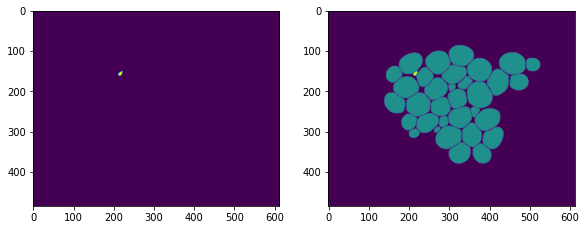

acdc_data3_20210722_pos_17_177
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0

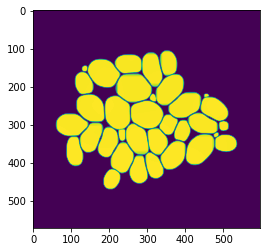

number of detections 40 u_sem 0.99947834 u_mask 0.93472224 u_box 0.93795663 u_det 1.0
number of detections 40 u_sem 0.9993126 u_mask 0.9466765 u_box 0.9540963 u_det 1.0
number of detections 40 u_sem 0.9994144 u_mask 0.9347926 u_box 0.94502604 u_det 1.0
number of detections 40 u_sem 0.99747604 u_mask 0.9031326 u_box 0.9371418 u_det 1.0
number of detections 40 u_sem 0.9937777 u_mask 0.93280965 u_box 0.94936836 u_det 1.0
number of detections 40 u_sem 0.99848014 u_mask 0.933651 u_box 0.9428531 u_det 1.0
number of detections 40 u_sem 0.9971113 u_mask 0.9483047 u_box 0.9611087 u_det 1.0
number of detections 40 u_sem 0.9930032 u_mask 0.92027366 u_box 0.9292593 u_det 1.0
number of detections 40 u_sem 0.9780365 u_mask 0.93541706 u_box 0.9344527 u_det 1.0
number of detections 40 u_sem 0.9921713 u_mask 0.9092686 u_box 0.91849583 u_det 1.0
number of detections 41 u_sem 0.96579653 u_mask 0.92970526 u_box 0.9444945 u_det 1.0
number of detections 40 u_sem 0.9921323 u_mask 0.94471985 u_box 0.9577015 u

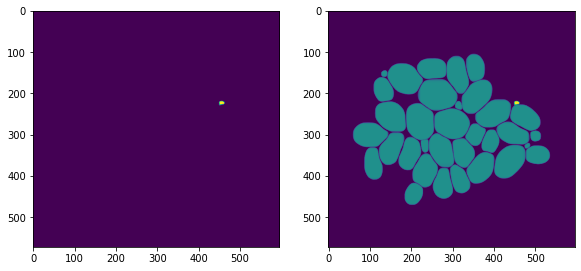

In [85]:

def show_uncertainties(im_json, model, query_strategy):
    print(im_json["image_id"])
    uncertainties = get_uncertainties(im_json, model, query_strategy)

    total_pred_mask = np.max(np.stack([np.mean(np.stack([val["pred_masks"] for val in uncertainty["val"]]), axis=0) for uncertainty in uncertainties]), axis = 0)

    show_image(total_pred_mask)
    for uncertainty in uncertainties:

        print("number of detections", len(uncertainty["val"]), "u_sem", uncertainty["u_sem"], "u_mask", uncertainty["u_mask"], "u_box", uncertainty["u_box"], "u_det", uncertainty["u_det"])

        if uncertainty["u_det"] < 1:
            mask = np.mean(np.stack([val["pred_masks"] for val in uncertainty["val"]]), axis=0)
            show_image([mask, total_pred_mask + mask], normalize=False)



for im_json in sample_data:
    show_uncertainties(im_json, model, query_strategy)